<a href="https://colab.research.google.com/github/YM2132/QMML/blob/main/lesson_11_gesture_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This session will see us attempting to apply deep learning to a Kaggle task. I hope it is an insight into the applicability of machine learning and the sorts of things it allows us to do!

It will not be very theoretical, but it should be fun.

Kaggle link: https://www.kaggle.com/competitions/state-farm-distracted-driver-detection/overview

We are classifying images based on what is happening within them (you can take many different approaches to this task), I will approach this as a gesture recognition task. We will use a prepackaged solution provided by google (mediapipe), in the future we may look at implementing this ourselves.

We will use the hand gesture recognition model (https://storage.googleapis.com/mediapipe-assets/gesture_recognizer/model_card_hand_gesture_classification_with_faireness_2022.pdf) and fine tune it for our task.

The data has 10 categories, which can be found in the overview page. We must add a new category labelled none


In [ ]:
# Lets download the dataset from Kaggle
# To do so you need to create a kaggle.json and upload it in the next code box. This can be done in your account section on Kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!pip install -q kaggle

In [ ]:
import os

# Make a directory for Kaggle and move the Kaggle API credentials file there
os.makedirs('/root/.kaggle/', exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Change the permissions of the file.
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 3.99G/4.00G [00:56<00:00, 107MB/s] 
100% 4.00G/4.00G [00:56<00:00, 75.4MB/s]


In [ ]:
!unzip state-farm-distracted-driver-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r /content/state_farm /content/drive/MyDrive/datasets

In [ ]:
import os
import cv2 as cv
import numpy as np

In [ ]:
# Lets do a quick overview of the data and take a look at what we are working with
# There are 10 categories, lets see how many of each we have

train = '/content/state_farm/imgs/train'

total = 0
cats = []

for cat in sorted(os.listdir(train)):
    if cat == '.DS_Store':
        continue
    print(cat, len(os.listdir(f'{train}/{cat}')))
    cats.append(len(os.listdir(f'{train}/{cat}')))

total = sum(cats)
print(f'Total train images: {total}')

# So we have around 10% for each category
# Now lets have a look at the image size, as this matters for input to our model
# The model requires us to input images as 192 x 192 or 224 x 224 pixel images
test_img = cv.imread('/content/state_farm/imgs/train/c0/img_34.jpg')
print(test_img.shape)

c0 2489
c1 2267
c2 2317
c3 2346
c4 2326
c5 2312
c6 2325
c7 2002
c8 1911
c9 2129
Total train images: 22424
(480, 640, 3)


In [ ]:
!pip install --upgrade pip
!pip install mediapipe-model-maker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import the required libraries for mediapipe
from google.colab import files
import os
import tensorflow as tf
assert tf.__version__.startswith('2')

from mediapipe_model_maker import gesture_recognizer

import matplotlib.pyplot as plt

In [31]:
# We will create an 80 - 10 - 10 split on our train dataset
dataset_path = '/content/state_farm/imgs/train'

# This is code from the mediapipe library
# We must add a none folder to the dataset as the mediapipe requires a "none" category
data = gesture_recognizer.Dataset.from_folder(
    dirname=dataset_path,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

Using existing files at /tmp/model_maker/gesture_recognizer/palm_detection_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/hand_landmark_full.tflite


In [32]:
hparams = gesture_recognizer.HParams(export_dir="exported_model")
options = gesture_recognizer.GestureRecognizerOptions(hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer  [(None, 128)]             0         
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 custom_gesture_recognizer_  (None, 12)                1548      
 out (Dense)                                                     
                                                             

In [33]:
loss, acc = model.evaluate(test_data, batch_size=1)
print(f"Test loss:{loss}, Test accuracy:{acc}")

1720/1720 [==============================] - 18s 5ms/step - loss: 1.0922 - categorical_accuracy: 0.5145
Test loss:1.0922157764434814, Test accuracy:0.5145348906517029


In [34]:
model.export_model()
!ls exported_model

Using existing files at /tmp/model_maker/gesture_recognizer/palm_detection_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/hand_landmark_full.tflite
best_model_weights.data-00000-of-00001	checkpoint    gesture_recognizer.task  metadata.json
best_model_weights.index		epoch_models  logs


In [35]:
files.download('exported_model/gesture_recognizer.task')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python.vision import

In [37]:
model_path = '/content/exported_model/gesture_recognizer.task'

In [39]:
base_options = python.BaseOptions(model_asset_path=model_path)

In [53]:
test_dir_path = '/content/state_farm/imgs/test'

# List all files in the directory
IMAGE_FILENAMES = [os.path.join(test_dir_path, f) for f in os.listdir(test_dir_path) if os.path.isfile(os.path.join(test_dir_path, f))]
print('Files in the directory:', IMAGE_FILENAMES[0])

subset_imgs = IMAGE_FILENAMES[:10]


Files in the directory: /content/state_farm/imgs/test/img_87125.jpg


/content/state_farm/imgs/test/img_87125.jpg


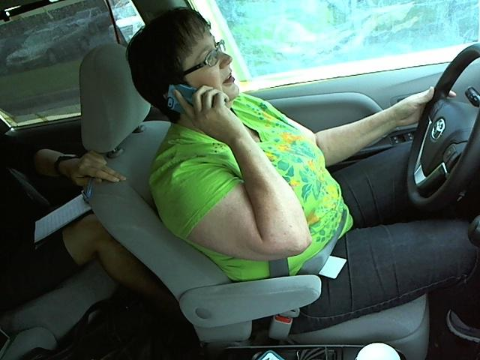

/content/state_farm/imgs/test/img_96951.jpg


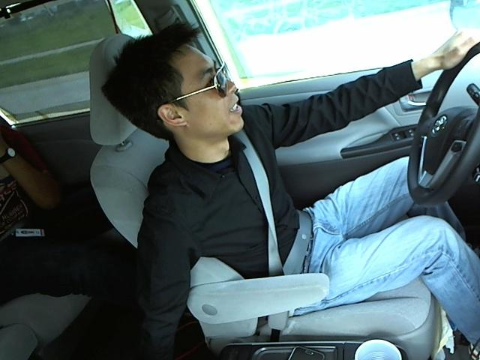

/content/state_farm/imgs/test/img_10769.jpg


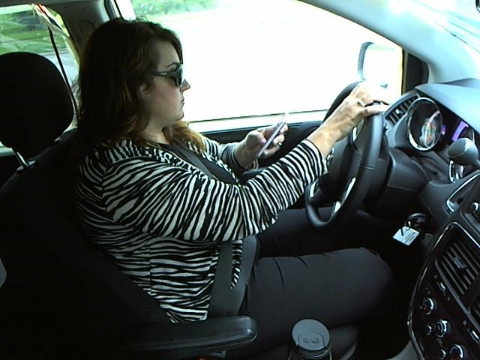

/content/state_farm/imgs/test/img_78933.jpg


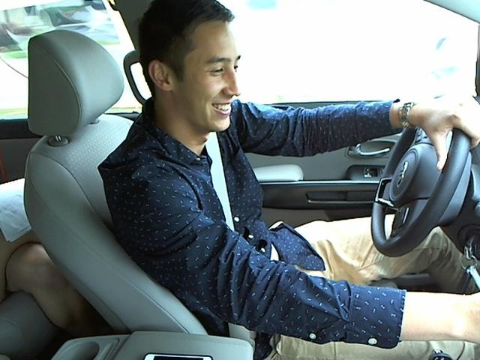

/content/state_farm/imgs/test/img_94236.jpg


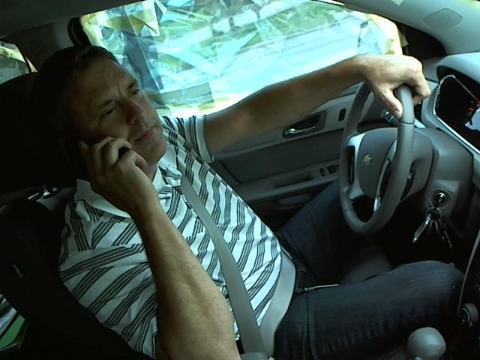

/content/state_farm/imgs/test/img_87425.jpg


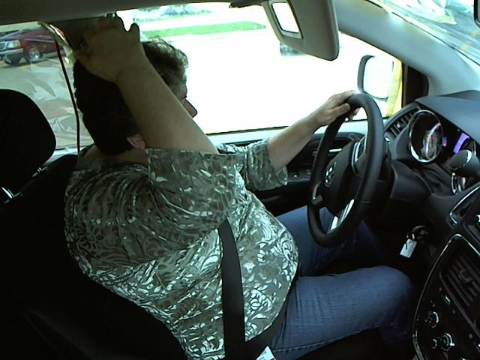

/content/state_farm/imgs/test/img_64564.jpg


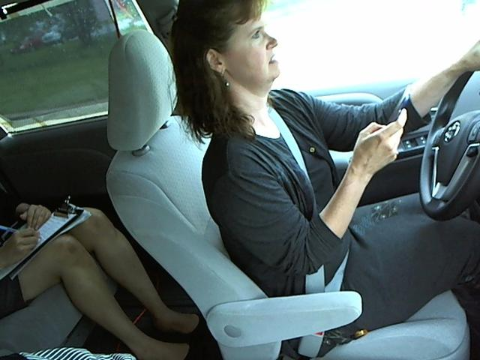

/content/state_farm/imgs/test/img_25714.jpg


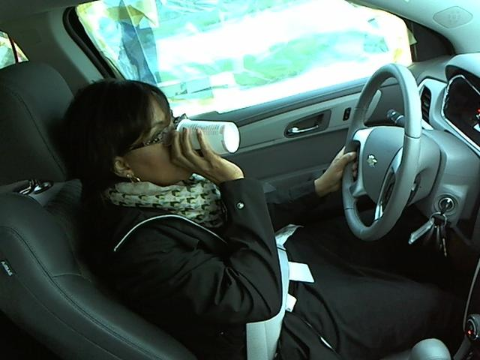

/content/state_farm/imgs/test/img_89145.jpg


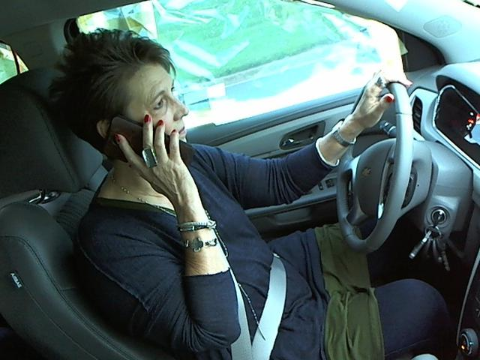

/content/state_farm/imgs/test/img_92316.jpg


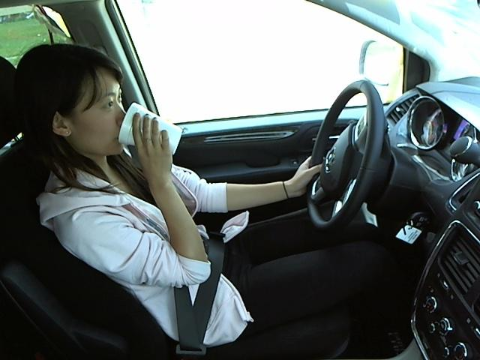

In [54]:
import cv2

from google.colab.patches import cv2_imshow
import math

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)


# Preview the images.
images = {name: cv2.imread(name) for name in subset_imgs}
for name, image in images.items():
  print(name)
  resize_and_show(image)



In [58]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an GestureRecognizer object.
base_options = python.BaseOptions(model_asset_path='/content/exported_model/gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)

images = []
results = []
for image_file_name in subset_imgs:
  # STEP 3: Load the input image.
  image = mp.Image.create_from_file(image_file_name)

  # STEP 4: Recognize gestures in the input image.
  recognition_result = recognizer.recognize(image)
  print(recognition_result[0][0])

  # STEP 5: Process the result. In this case, visualize it.
  images.append(image)
  top_gesture = recognition_result.gestures[0][0]
  hand_landmarks = recognition_result.hand_landmarks
  results.append((top_gesture, hand_landmarks))

display_batch_of_images_with_gestures_and_hand_landmarks(images, results)

TypeError: 'GestureRecognizerResult' object is not subscriptable